In [1]:
#!/usr/bin/env python

import sys
sys.path.append('../../')

import os
import argparse
import tensorflow as tf
import random
import numpy as np

from rl_server.rl_server import RLServer
from rl_server.algo.qqtt_ddpg import QQTTDDPG as DDPG
from rl_server.networks.qqtt_critic import *
from misc.experiment_config import ExperimentConfig

In [2]:
seed = 1
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)

C = ExperimentConfig(env_name='pendulum', experiment_name='qqtt2')

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(C.gpu_id)

observation_shapes = [(C.obs_size,)]
state_shapes = [(C.history_len, C.obs_size,)]

critic = QQTTCriticNetwork(state_shapes[0], C.action_size, tt_rank=8,
                           partition_size=64, scope='critic')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_input (InputLayer)        (None, 1, 3)         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 3)            0           state_input[0][0]                
__________________________________________________________________________________________________
action_input (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 3)            0           reshape_1[0][0]                  
__________________________________________________________________________________________________
lambda_2 (

In [3]:
tf.trainable_variables()

[<tf.Variable 'critic/qt_layer/Q/core_0:0' shape=(1, 64, 8) dtype=float32_ref>,
 <tf.Variable 'critic/qt_layer/Q/core_1:0' shape=(8, 64, 8) dtype=float32_ref>,
 <tf.Variable 'critic/qt_layer/Q/core_2:0' shape=(8, 64, 8) dtype=float32_ref>,
 <tf.Variable 'critic/qt_layer/Q/core_3:0' shape=(8, 64, 1) dtype=float32_ref>]

In [4]:
def model_load_callback(sess, saver):
    #pass
    # examples of loading checkpoint
    saver.restore(sess, 'results/qqtt2/ckpt/model-100000.ckpt')

agent_algorithm = DDPG(state_shapes=state_shapes,
                       action_size=C.action_size,
                       critic=critic,
                       critic_optimizer=tf.train.AdamOptimizer(learning_rate=1e-3),
                       n_step=C.n_step,
                       discount_factor=C.disc_factor,
                       target_critic_update_rate=1e-2)

rl_server = RLServer(num_clients=40,
                     action_size=C.action_size,
                     observation_shapes=observation_shapes,
                     state_shapes=state_shapes,
                     model_load_callback=model_load_callback,
                     agent_algorithm=agent_algorithm,
                     action_dtype=tf.float32,
                     is_actions_space_continuous=True,
                     gpu_id=C.gpu_id,
                     batch_size=C.batch_size,
                     experience_replay_buffer_size=1000000,
                     use_prioritized_buffer=C.use_prioritized_buffer,
                     use_synchronous_update=C.use_synchronous_update,
                     train_every_nth=1,
                     history_length=C.history_len,
                     start_learning_after=500,
                     target_critic_update_period=1,
                     target_actor_update_period=2,
                     show_stats_period=100,
                     save_model_period=10000,
                     init_port=C.port,
                     ckpt_path=C.path_to_ckpt)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_input (InputLayer)        (None, 1, 3)         0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 3)            0           state_input[0][0]                
__________________________________________________________________________________________________
action_input (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 3)            0           reshape_2[0][0]                  
__________________________________________________________________________________________________
lambda_6 (

In [5]:
tf.trainable_variables()

[<tf.Variable 'critic/qt_layer/Q/core_0:0' shape=(1, 64, 8) dtype=float32_ref>,
 <tf.Variable 'critic/qt_layer/Q/core_1:0' shape=(8, 64, 8) dtype=float32_ref>,
 <tf.Variable 'critic/qt_layer/Q/core_2:0' shape=(8, 64, 8) dtype=float32_ref>,
 <tf.Variable 'critic/qt_layer/Q/core_3:0' shape=(8, 64, 1) dtype=float32_ref>,
 <tf.Variable 'target_critic/target_critic/qt_layer/Q/core_0:0' shape=(1, 64, 8) dtype=float32_ref>,
 <tf.Variable 'target_critic/target_critic/qt_layer/Q/core_1:0' shape=(8, 64, 8) dtype=float32_ref>,
 <tf.Variable 'target_critic/target_critic/qt_layer/Q/core_2:0' shape=(8, 64, 8) dtype=float32_ref>,
 <tf.Variable 'target_critic/target_critic/qt_layer/Q/core_3:0' shape=(8, 64, 1) dtype=float32_ref>]

In [6]:
sess = rl_server._train_loop._sess

In [7]:
cores = tf.trainable_variables()[:4]

In [8]:
tt = t3f.TensorTrain(cores)

In [9]:
tt_full = t3f.full(tt)

In [10]:
tt_full_ = sess.run(tt_full)

In [11]:
tmp = np.max(tt_full_, axis=-1)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

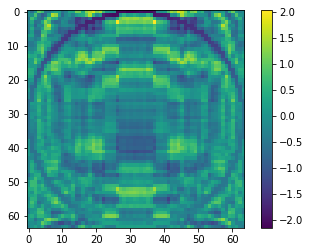

In [27]:
plt.imshow(tmp[:, :, 32])
plt.colorbar()

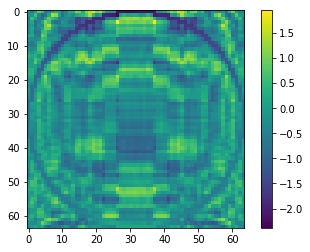

In [31]:
plt.imshow(tt_full_[:,:,32,32])
plt.colorbar()

In [22]:
tmp.shape

(64, 64, 64)

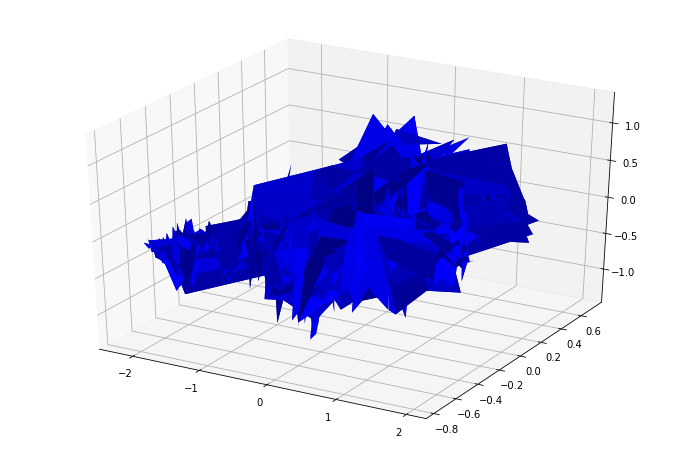

In [26]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Make data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 10 * np.outer(np.cos(u), np.sin(v))
y = 10 * np.outer(np.sin(u), np.sin(v))
z = 10 * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(tmp[0,:,:], tmp[:,0,:], tmp[:,:,0], color='b')

plt.show()

In [32]:
import gym

In [33]:
env = gym.make('Pendulum-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [39]:
env.observation_space.high

array([1., 1., 8.], dtype=float32)